# My SSGA

In [11]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import EntropyRateSuperpixel as ERS
import MyDataset as Data
import LambdaCoeff as LC

import SSGA

### Import dataset

145 145 200


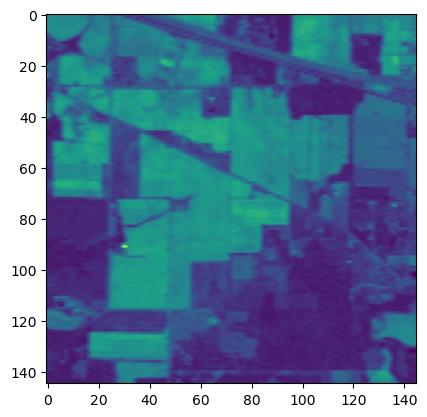

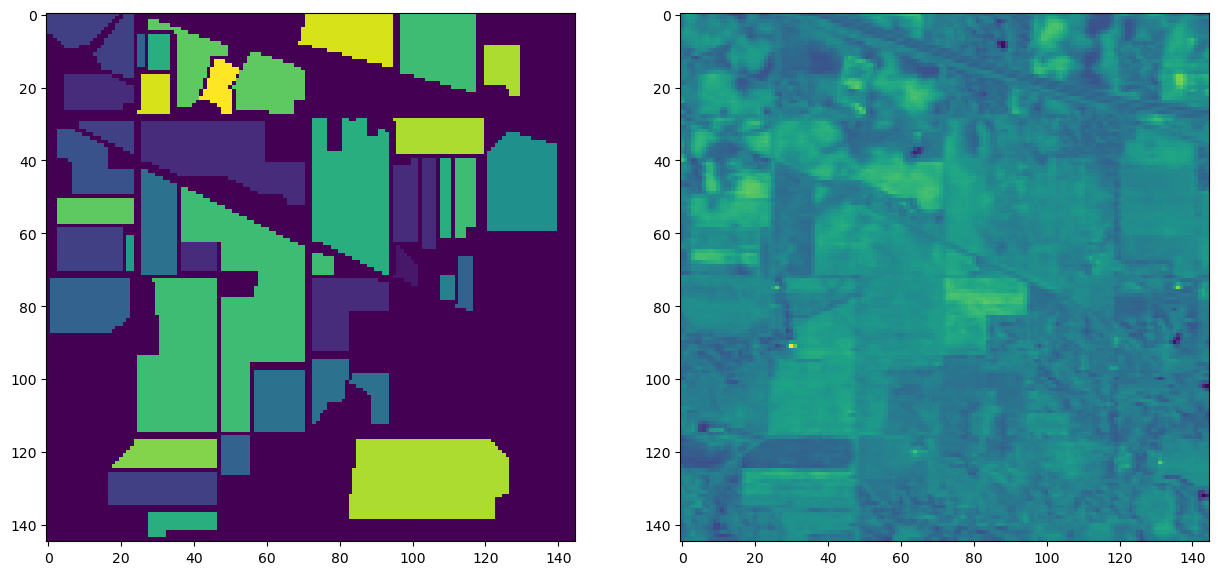

In [2]:

usedDataset = Data.IndianPines
#usedDataset = Data.PaviaUniversity
#usedDataset = Data.PaviaCenter


N,M,B = usedDataset["shape"]
print(N,M,B)


b = np.random.randint(0, B-1)
plt.imshow(usedDataset["data"][:,:,b])
plt.show()
fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(usedDataset["gt"])
axs[1].imshow(np.average(usedDataset["data"], axis=2))
plt.show()

### Compute SPs

In [6]:
K = 200
trainData = Data.standardize_data(usedDataset["data"])
SPs = ERS.find_superpixel(trainData, K, int(LC.getLambdaNorm1(K,N,M)), ERS.complete_norm1_similarity, True)
Classifiers = {b:ERS.SuperpixelClassifier(SPs, usedDataset["labels"], usedDataset["gt"], counting0=b) for b in [True, False]}

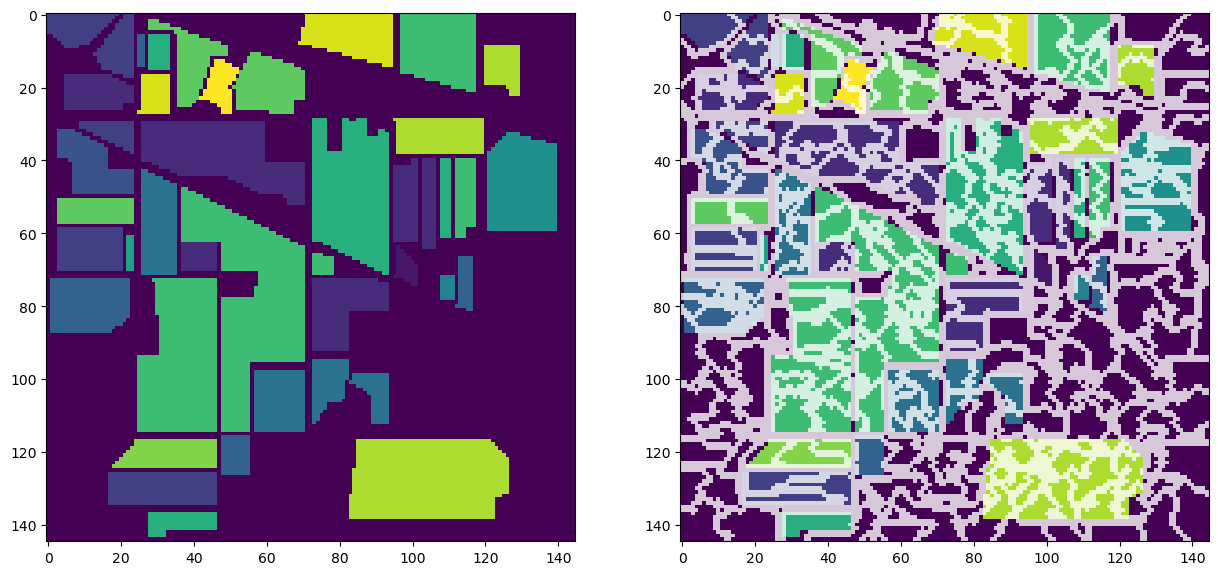

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(usedDataset["gt"])
axs[1].imshow(usedDataset["gt"])
axs[1].imshow(ERS.create_overlay_borders(usedDataset["gt"], SPs, color=[255,255,255,200]))
plt.show()

### Merge SPs

In [8]:
def SP_average(data, SP):
    N,M,B = data.shape
    res = np.zeros(B)
    for x,y in SP:
        res += data[x,y,:]
    return res/len(SP)


def squaredDist(a, b):
    return (a[0]-b[0])**2 + (a[1]-b[1])**2

def SP_weighted_average(data, SP):
    c = np.average(SP, axis=0)
    dists = np.array([np.exp(-squaredDist(a, c)**0.5) for a in SP])
    if dists.max()-dists.min()!=0:
        dists = (dists-dists.min())/(dists.max()-dists.min())
    else:
        dists = [1/len(dists) for _ in range(len(SP))]

    N,M,B = data.shape
    res = np.zeros(B)
    for i,(x,y) in enumerate(SP):
        res += dists[i] * data[x,y,:]
    return res/len(SP)


def norm1(x,y):
    return np.abs(x-y).sum()/len(x)

def norm2(x,y):
    return ((x-y)**2).sum()/len(x)


def merge_SPs_basic(data, SPs, L, simFun=norm1):
    nb_SPs = len(SPs)
    existing = [True for _ in range(nb_SPs)]
    SPs_liste = [[SP, SP_average(data, SP)] for SP in SPs]
    weights = [{j:simFun(SPs_liste[i][1], SPs_liste[j][1]) for j in range(i+1, nb_SPs)} for i in range(nb_SPs)]

    while nb_SPs>L:
        minimun = None
        argmin = None
        for k1 in range(len(SPs)):
            if existing[k1]:
                for k2 in weights[k1].keys():
                    if existing[k2]:
                        if minimun==None or weights[k1][k2]<minimun:
                            argmin = (k1, k2)
                            minimun = weights[k1][k2]
        k1,k2 = argmin
        SP_union = SPs_liste[k1][0] + SPs_liste[k2][0]
        SPs_liste[k1] = [SP_union, SP_average(data, SP_union)] #Opti to compute average easy without dividing by len(SP)
        existing[k2] = False

        for k in range(k1+1, len(SPs)):
            if existing[k]:
                weights[k1][k] = simFun(SPs_liste[k1][1], SPs_liste[k][1])
        for k in range(k1):
            if existing[k]:
                weights[k][k1] = simFun(SPs_liste[k1][1], SPs_liste[k][1])
        nb_SPs -= 1
    
    return [SPs_liste[i][0] for i in range(len(SPs)) if existing[i]]
       


def merge_SPs_v2(data, SPs, L, simFun=norm1):
    nb_SPs = len(SPs)
    existing = [True for _ in range(nb_SPs)]
    SPs_liste = [[SP, SP_weighted_average(data, SP), 1] for SP in SPs]
    weights = [{j:simFun(SPs_liste[i][1], SPs_liste[j][1]) for j in range(i+1, nb_SPs)} for i in range(nb_SPs)]

    while nb_SPs>L:
        minimun = None
        argmin = None
        for k1 in range(len(SPs)):
            if existing[k1]:
                for k2 in weights[k1].keys():
                    if existing[k2]:
                        if minimun==None or weights[k1][k2]<minimun:
                            argmin = (k1, k2)
                            minimun = weights[k1][k2]
        k1,k2 = argmin
        SP_union = SPs_liste[k1][0] + SPs_liste[k2][0]
        count = max(SPs_liste[k1][2], SPs_liste[k2][2])
        SPs_liste[k1] = [SP_union, SPs_liste[k1][1] + SPs_liste[k2][1], count+1] #Opti to compute average easy without dividing by len(SP)
        existing[k2] = False

        for k in range(k1+1, len(SPs)):
            if existing[k]:
                weights[k1][k] = simFun(SPs_liste[k1][1]/SPs_liste[k1][2], SPs_liste[k][1]/SPs_liste[k][2])
        for k in range(k1):
            if existing[k]:
                weights[k][k1] = simFun(SPs_liste[k1][1]/SPs_liste[k1][2], SPs_liste[k][1]/SPs_liste[k][2])
        nb_SPs -= 1
    
    return [SPs_liste[i][0] for i in range(len(SPs)) if existing[i]]
       

    
        
from sklearn.cluster import KMeans
def merge_SPs_kmeans(data, SPs, L):
    nb_cluster = L
    kmeans = KMeans(n_clusters=nb_cluster, n_init="auto")
    features = [SP_average(data, SP) for SP in SPs]
    kmeans.fit(features)

    SPs_merged = [[] for _ in range(nb_cluster)]
    for i in range(len(kmeans.labels_)):
        SPs_merged[kmeans.labels_[i]] += SPs[i]
    return SPs_merged



from sklearn.cluster import AgglomerativeClustering
def merge_Sps_agglomerative(data, SPs, L):
    features = [SP_average(data, SP) for SP in SPs]
    clustering = AgglomerativeClustering(n_clusters=L, linkage='ward')
    labels = clustering.fit_predict(features)

    SPs_merged = [[] for _ in range(L)]
    for i in range(len(labels)):
        SPs_merged[labels[i]] += SPs[i]
    return SPs_merged


from sklearn.cluster import SpectralClustering
def merge_Sps_spectral(data, SPs, L):
    features = [SP_average(data, SP) for SP in SPs]
    clustering = SpectralClustering(n_clusters=L, affinity='nearest_neighbors', assign_labels='kmeans')
    labels = clustering.fit_predict(features)

    SPs_merged = [[] for _ in range(L)]
    for i in range(len(labels)):
        SPs_merged[labels[i]] += SPs[i]
    return SPs_merged


In [9]:
dataForMerges = Data.standardize_data(usedDataset["data"])
SPsUsedForMerges = {b:[SP.pixels for SP in Classifiers[b].SPs] for b in Classifiers.keys()}

print("number of labels:", len(usedDataset["labels"]))
L = 15
mergedSPsDic = {key:[SPs,
             merge_SPs_basic(dataForMerges, SPs, L, simFun=norm2),
             merge_SPs_v2(dataForMerges, SPs, L, simFun=norm2),
             merge_SPs_kmeans(dataForMerges, SPs, L),
             merge_Sps_agglomerative(dataForMerges, SPs, L),
             merge_Sps_spectral(dataForMerges, SPs, L)]

             for key,SPs in SPsUsedForMerges.items()}

merged_SPs_names = ["without", "basic", "v2", "kmeans", "agglomerative", "SpectralClustering"]

number of labels: 17


/usr/lib/python3/dist-packages/sklearn/cluster/_spectral.py:701: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


200
[141, 84, 92, 114, 130, 146, 150, 108, 74, 97, 80, 94, 74, 112, 82, 115, 169, 116, 63, 71, 87, 90, 125, 95, 108, 135, 83, 98, 72, 110, 91, 94, 99, 84, 87, 122, 65, 97, 93, 127, 73, 127, 92, 96, 73, 81, 103, 156, 95, 140, 88, 88, 71, 83, 100, 120, 114, 140, 109, 76, 111, 77, 80, 89, 120, 78, 79, 85, 93, 122, 125, 128, 90, 135, 114, 138, 100, 89, 58, 118, 97, 106, 120, 101, 86, 101, 86, 102, 89, 147, 115, 98, 133, 65, 107, 80, 134, 104, 104, 98, 160, 69, 120, 80, 72, 83, 132, 96, 88, 106, 92, 81, 97, 70, 167, 99, 119, 127, 89, 100, 118, 105, 142, 79, 75, 94, 126, 76, 106, 103, 118, 99, 126, 153, 145, 131, 148, 76, 140, 166, 114, 88, 103, 134, 142, 88, 106, 121, 89, 130, 156, 86, 106, 100, 72, 98, 129, 114, 81, 111, 121, 127, 69, 74, 119, 94, 95, 145, 80, 82, 103, 146, 142, 102, 82, 131, 166, 105, 113, 79, 65, 104, 117, 90, 97, 125, 100, 113, 64, 134, 80, 119, 107, 141, 132, 71, 114, 74, 140, 121]
146
[12, 53, 90, 127, 150, 104, 1, 94, 60, 66, 91, 72, 127, 48, 43, 34, 68, 2, 55, 94, 1

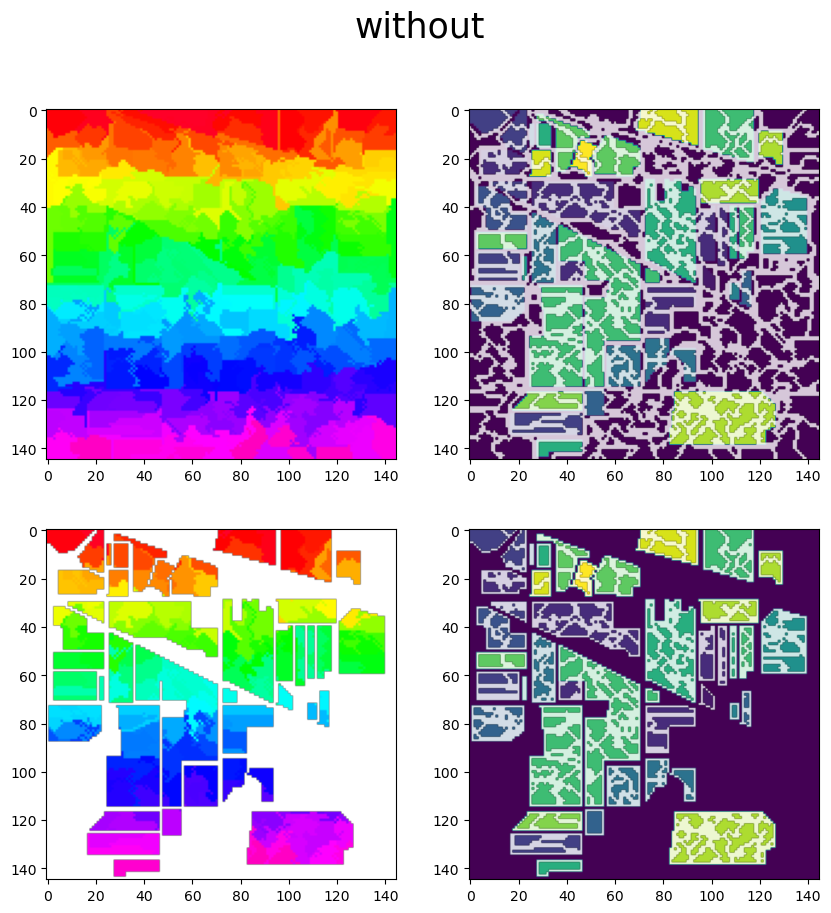

15
[1543, 209, 787, 4900, 741, 953, 5025, 507, 3673, 269, 1381, 100, 285, 467, 185]
15
[1473, 425, 205, 1201, 4380, 956, 129, 160, 162, 144, 2, 253, 413, 142, 204]


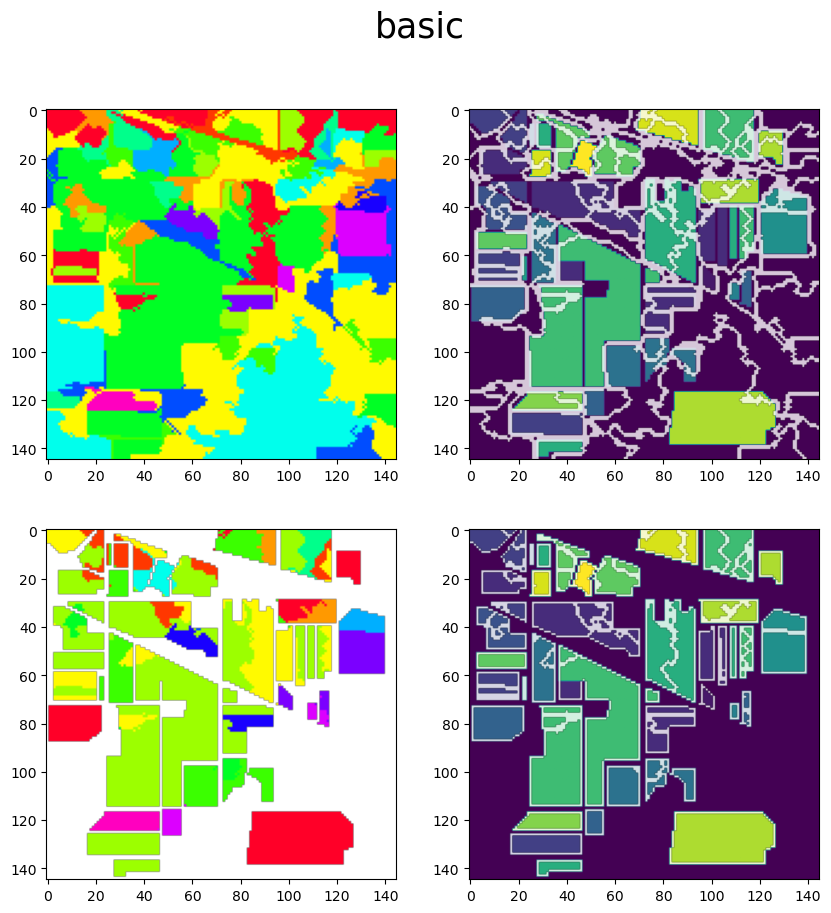

15
[1744, 1912, 864, 2663, 5504, 4460, 642, 90, 673, 100, 1312, 262, 654, 80, 65]
15
[1705, 583, 5000, 1250, 1, 102, 2, 893, 1, 698, 1, 2, 1, 1, 9]


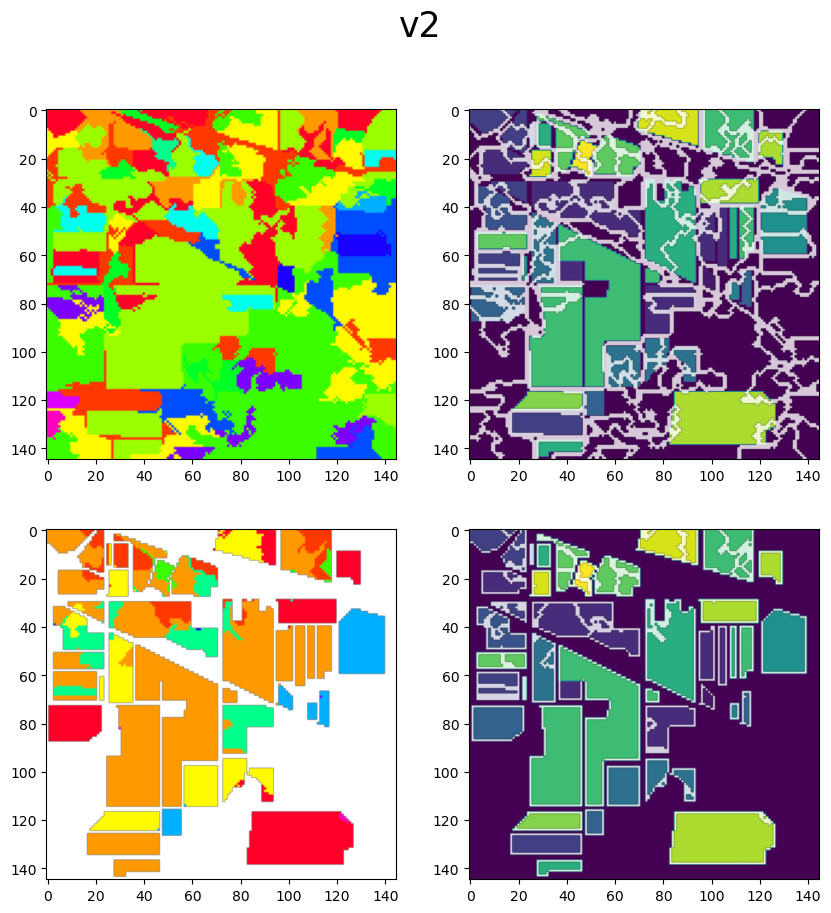

15
[1080, 1832, 2708, 1742, 2614, 924, 2033, 1431, 687, 1017, 1034, 1620, 567, 1467, 269]
15
[1959, 869, 236, 356, 253, 343, 819, 1168, 257, 1780, 204, 530, 415, 468, 592]


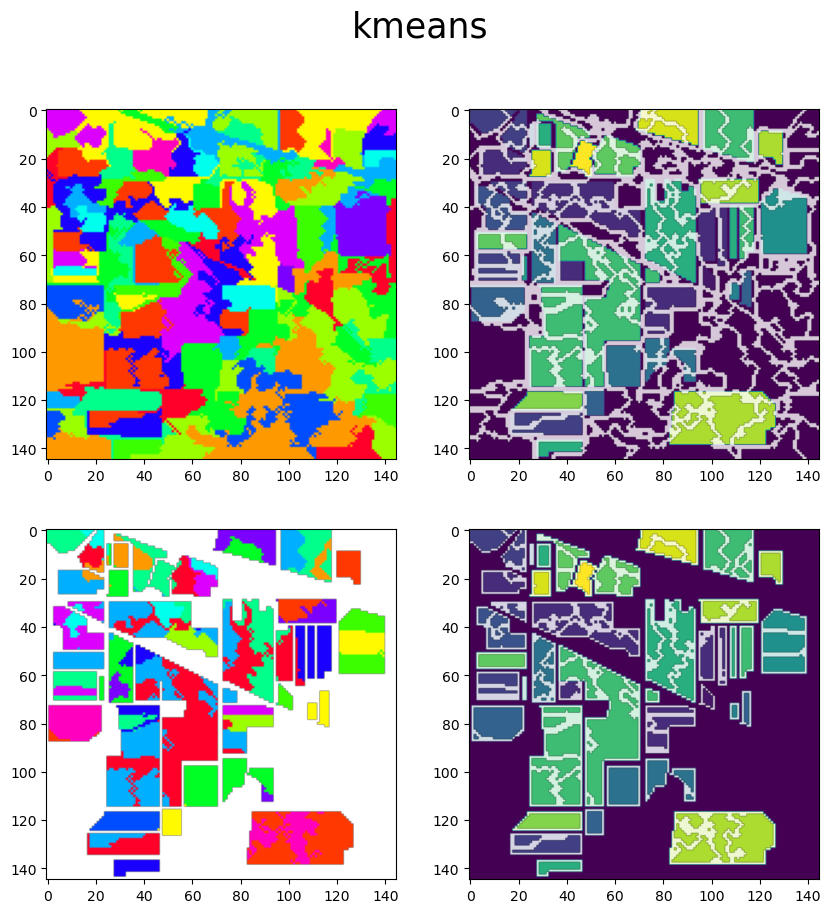

15
[2954, 1810, 1032, 2564, 1617, 1274, 2514, 1781, 362, 470, 409, 1027, 2265, 677, 269]
15
[713, 1845, 1228, 2132, 343, 493, 828, 403, 358, 648, 506, 162, 204, 253, 133]


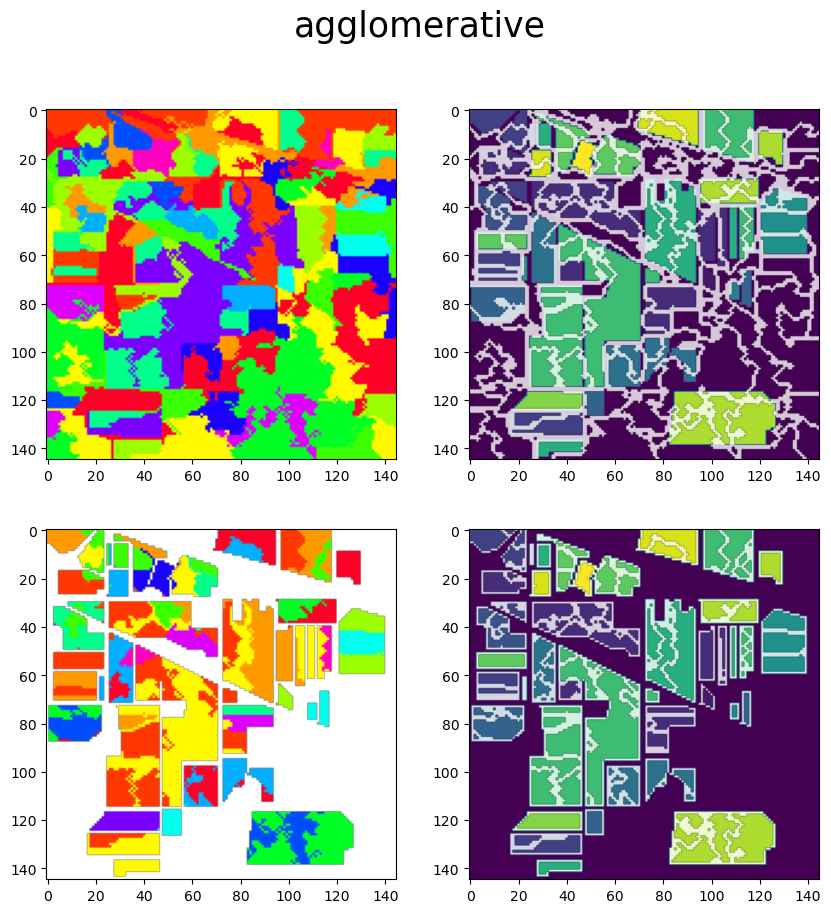

15
[1295, 1988, 1730, 1595, 1574, 1102, 835, 1514, 819, 1499, 1972, 1544, 1419, 932, 1207]
15
[766, 742, 701, 976, 911, 493, 1104, 479, 613, 685, 592, 881, 340, 258, 708]


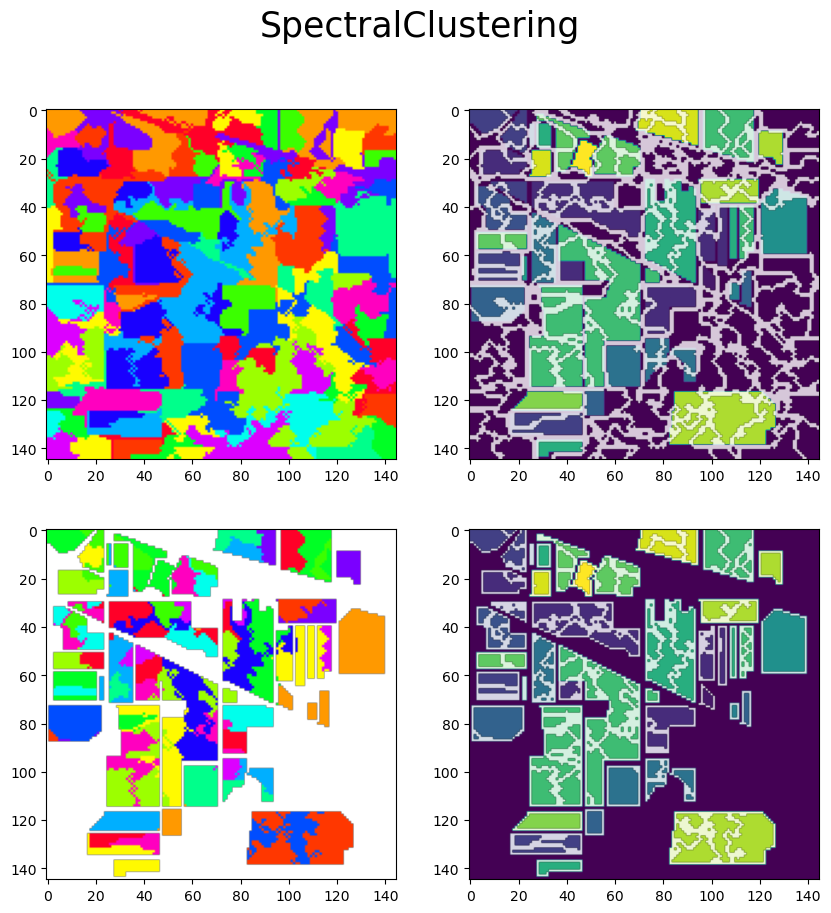

In [12]:
length = len(merged_SPs_names)
for i in range(length):

    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    cmap = mpl.colormaps["gist_rainbow"]
    #np.random.shuffle(colors)
    n,m,_ = dataForMerges.shape

    for k,key in enumerate(mergedSPsDic.keys()):
        SPs = mergedSPsDic[key][i]
        colors = cmap(np.linspace(0, 1, len(SPs)))
        print(len(SPs))
        print([len(SP) for SP in SPs])
        img = np.zeros((n,m,len(colors[0])))
        for j,SP in enumerate(SPs):
            for x,y in SP:
                img[x,y] = colors[j]

        axs[k][0].imshow(img)

        axs[k][1].imshow(usedDataset["gt"])
        mask = ERS.create_overlay_borders(usedDataset["gt"], SPs, color=[255,255,255,200])
        axs[k][1].imshow(mask)

    fig.suptitle(merged_SPs_names[i], fontsize=25)
    plt.show()